# Image Recognition Model

## Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from tensorflow.keras import layers, Sequential, regularizers 
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Checking TensorFlow version
print(tf.__version__)

2024-05-24 15:35:01.054356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 15:35:02.419259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


## Importing Dataset

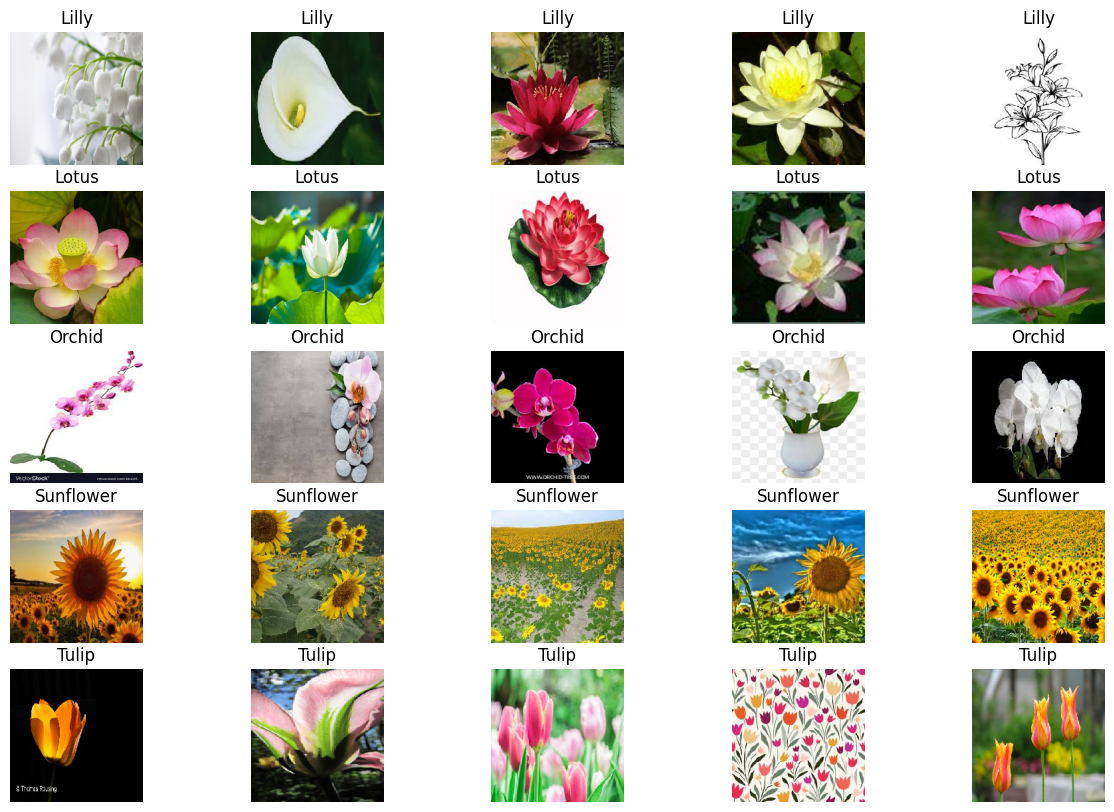

Training Set Class Distribution: {'Lilly': 1248, 'Lotus': 958, 'Orchid': 920, 'Sunflower': 1609, 'Tulip': 1601}


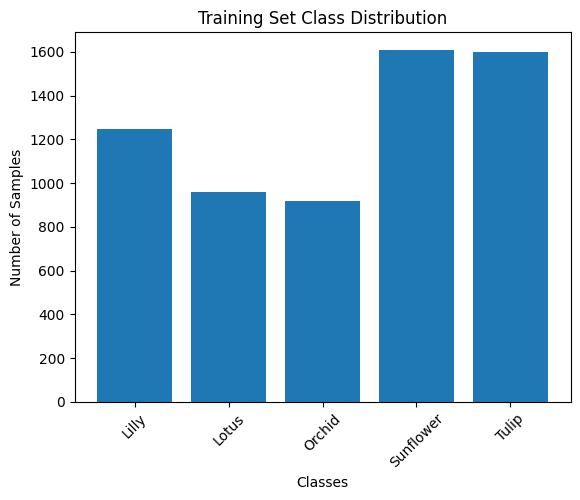

Testing Set Class Distribution: {'Lilly': 348, 'Lotus': 241, 'Orchid': 214, 'Sunflower': 399, 'Tulip': 383}


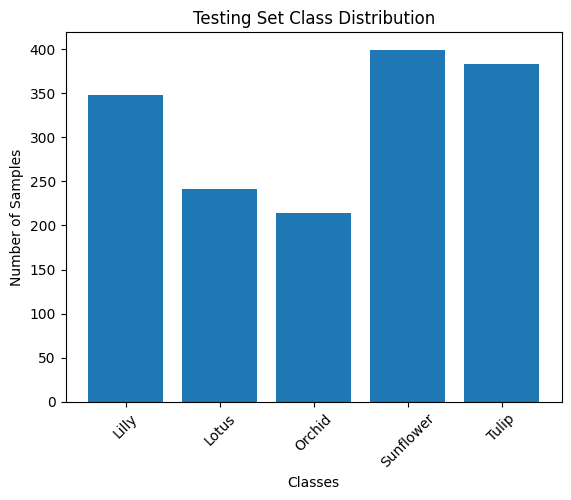

In [2]:
data_dir = 'flower_images'

# List of flower classes (subdirectories)
classes = os.listdir(data_dir)
num_classes = len(classes)

X = []
y = []

# Load images and labels
for i, cls in enumerate(classes):
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(200,200))  
        img_array = img_to_array(img)
        X.append(img_array)
        y.append(i)  


X = np.array(X)
y = np.array(y)


y = to_categorical(y, num_classes=num_classes)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


num_samples_per_class = 5
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    class_indices = np.where(np.argmax(y_train, axis=1) == i)[0]
    sampled_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    for j, idx in enumerate(sampled_indices):
        plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
        plt.imshow(X_train[idx].astype(np.uint8))
        plt.title(cls)
        plt.axis('off')

plt.show()

class_distribution_train = {cls: np.sum(np.argmax(y_train, axis=1) == i) for i, cls in enumerate(classes)}
print("Training Set Class Distribution:", class_distribution_train)

plt.bar(class_distribution_train.keys(), class_distribution_train.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)
plt.show()

class_distribution_test = {cls: np.sum(np.argmax(y_test, axis=1) == i) for i, cls in enumerate(classes)}
print("Testing Set Class Distribution:", class_distribution_test)

plt.bar(class_distribution_test.keys(), class_distribution_test.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Testing Set Class Distribution')
plt.xticks(rotation=45)
plt.show()



## Preprocessing the Data

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)


## Defining the Model

### Adding an Attention Layer

In [4]:
keras.saving.get_custom_objects().clear()

@keras.saving.register_keras_serializable()
class SelfAttention(layers.Layer):
    def __init__(self, units,**kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.units = units
        self.W = layers.Dense(units)
        self.U = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, inputs):
        query = self.W(inputs)
        key = self.U(inputs)
        value = inputs

        score = tf.nn.tanh(query + key)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        context_vector = attention_weights * value
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

    def get_config(self):
        base_config = super(SelfAttention, self).get_config()
        config = {
            "units": keras.saving.serialize_keras_object(self.units),
            "W": keras.saving.serialize_keras_object(self.W),
            "U": keras.saving.serialize_keras_object(self.U),
            "V": keras.saving.serialize_keras_object(self.V),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        units_conf = config.pop("units")
        W_conf = config.pop("W")
        U_conf = config.pop("U")
        V_conf = config.pop("V")

        units = keras.saving.deserialize_keras_object(units_conf)
        W = keras.saving.deserialize_keras_object(W_conf)
        U = keras.saving.deserialize_keras_object(U_conf)
        V = keras.saving.deserialize_keras_object(V_conf)
        return cls(units, W, U, V,**config)

### Learning Rate Adjustment & Early Stopping

In [5]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [6]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Reshape((-1, 256)),  
    SelfAttention(256),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()
model.save("flower_test.keras")

/run/media/jaswin/Data/Class/College/NM/Oracle AI Project/final-code/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-24 15:35:40.279419: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 15:35:41.013004: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 256)            │       131,841 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,254 (2.25 MB)

 Trainable params: 588,294 (2.24 MB)

 Non-trainable params: 960 (3.75 KB)

## Training and Testing the Model

Epoch 1/60


/run/media/jaswin/Data/Class/College/NM/Oracle AI Project/final-code/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716545148.123288   35725 service.cc:145] XLA service 0x7f3ad4097950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716545148.124306   35725 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-24 15:35:48.391353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-24 15:35:48.868108: I external/local_xla/xla/stream_executor

  1/198 ━━━━━━━━━━━━━━━━━━━━ 49:12 15s/step - accuracy: 0.2500 - loss: 5.0647

I0000 00:00:1716545158.070802   35725 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/198 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4466 - loss: 3.9998

I0000 00:00:1716545189.842017   35912 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3', 92 bytes spill stores, 92 bytes spill loads



198/198 ━━━━━━━━━━━━━━━━━━━━ 48s 167ms/step - accuracy: 0.4473 - loss: 3.9928 - val_accuracy: 0.2486 - val_loss: 2.7611 - learning_rate: 0.0010
Epoch 2/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step - accuracy: 0.5673 - loss: 2.0020 - val_accuracy: 0.4164 - val_loss: 1.8035 - learning_rate: 0.0010
Epoch 3/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - accuracy: 0.5878 - loss: 1.4617 - val_accuracy: 0.6492 - val_loss: 1.2536 - learning_rate: 0.0010
Epoch 4/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - accuracy: 0.6137 - loss: 1.2844 - val_accuracy: 0.6183 - val_loss: 1.1602 - learning_rate: 0.0010
Epoch 5/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.6138 - loss: 1.2214 - val_accuracy: 0.6101 - val_loss: 1.2220 - learning_rate: 0.0010
Epoch 6/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.6430 - loss: 1.1817 - val_accuracy: 0.6656 - val_loss: 1.0730 - learning_rate: 0.0010
Epoch 7/60
198/198 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.6243 - loss:

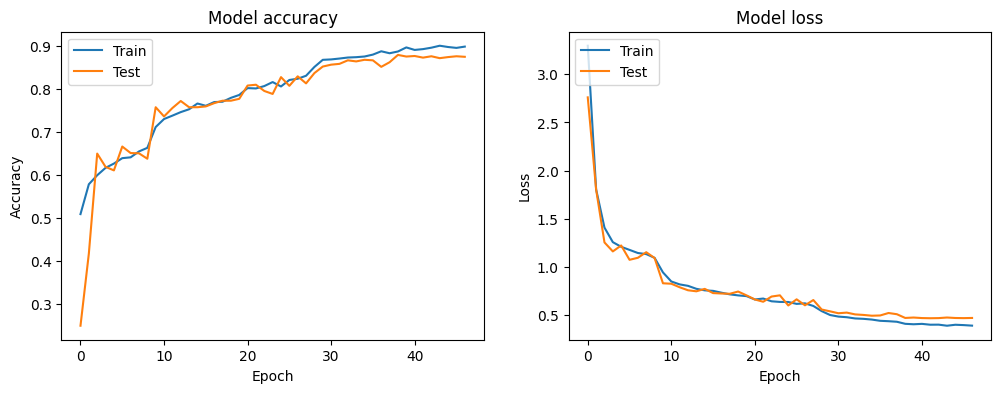

In [7]:
history = model.fit(train_generator, epochs=60, 
                    validation_data=validation_generator,
                    callbacks=[reduce_lr, early_stopping]
                    )

model.save('flower_test2.keras')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

keras.backend.clear_session()

In [8]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print(f'Test accuracy: {test_acc}')

50/50 - 1s - 14ms/step - accuracy: 0.8726 - loss: 0.4659
Test accuracy: 0.8725551962852478


## Making a Prediction

In [9]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(200, 200))  
    img_array = img_to_array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array

image_path = 'flower.jpg'
preprocessed_image = preprocess_image(image_path)

predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class[0]}')

class_names = os.listdir(data_dir)  

predicted_class_name = class_names[predicted_class[0]]
print(f'Predicted class name: {predicted_class_name}')

I0000 00:00:1716546586.553586   38046 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 92 bytes spill stores, 92 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: 0
Predicted class name: Lilly
